In [76]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import permutation_test

In [86]:
def test_by_betting(seq1, seq2, alpha=0.05): 
    # Construct wealth process from sequence X using ONS 
    
    wealth = 1
    wealth_hist = [1] 
    const = 2 / (2 - np.log(3))
    lambd = 0 
    zt2 = 0 
    for t in range(1,min(len(seq1), len(seq2))): 
                
        St = 1 - lambd*(seq1[t] - seq2[t])
        wealth = wealth * St 
        wealth_hist.append(wealth)
        if wealth > 1/alpha: 
            #print(f"Reject at time {t}")
            return wealth_hist, 'reject'
        
        # Update lambda via ONS  
        g = seq1[t] - seq2[t]
        z = g / (1 - lambd*g)
        zt2 += z**2
        lambd = max(min(lambd - const*z/(1 + zt2), 1/2), -1/2)
        
    U = np.random.uniform()
    if wealth > U/alpha: 
        return wealth_hist, 'reject'
    
    return wealth_hist, 'sustain'

def betting_experiment(seq1, seq2, alphas, n_iters=10): 

    results = []
    for _ in range(n_iters): 
        np.random.shuffle(seq1)
        np.random.shuffle(seq2)
        taus = []
        for alpha in alphas: 
            wealth, _ = test_by_betting(seq1, seq2, alpha=alpha)
            taus.append(len(wealth))
        results.append(taus)
        
    return results
            
           

In [3]:
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = (
    pd.read_excel(io=data_url, header=1)
    .drop(columns=["ID"])
    .rename(
        columns={"PAY_0": "PAY_1", "default payment next month": "default"}
    )
)

dataset.shape

(30000, 24)

In [4]:
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
train_inds = np.random.choice(dataset.shape[0], 10000, replace=False)
df_train = dataset.iloc[train_inds]

X_train = df_train.drop(columns='default')
y_train = df_train['default']

In [6]:
X_train.shape, y_train.shape

((10000, 23), (10000,))

In [7]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [38]:
np.unique(dataset.EDUCATION)

array([0, 1, 2, 3, 4, 5, 6])

In [8]:
df_test = dataset[~dataset.index.isin(train_inds)]

In [45]:
df1 = df_test[(df_test.EDUCATION <= 1) & (df_test.default == 0)]
df2 = df_test[(df_test.EDUCATION >= 3) & (df_test.default == 0)]
X1 = df1.drop(columns='default')
X2 = df2.drop(columns='default')
X1.shape, X2.shape

((5759, 23), (2697, 23))

In [66]:
y1 = clf.predict(X1)
y2 = clf.predict(X2)

In [53]:
print(np.mean(y1), np.mean(y2))
print(np.mean(y1[:len(y2)]))

0.038201076575794406 0.07007786429365963
0.041156840934371525


In [87]:
def test_stat(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

def perm_test(seq1, seq2, p):    
    
    # because our statistic is vectorized, we pass `vectorized=True`
    # `n_resamples=np.inf` indicates that an exact test is to be performed
    res = permutation_test((seq1, seq2), test_stat, vectorized=True,
                           n_resamples=2000, alternative='two-sided')
    # print(res.pvalue)
    if res.pvalue <= p: 
        return True 
    return False
    
def seq_perm_test(seq1, seq2, p=0.05, k=100, bonferroni=False): 
    
    l = min(len(seq1), len(seq2))
    for i in range(int(l/k)): 
        pi = p / 2**(i+1) if bonferroni else p
        if perm_test(seq1[i*k:k*(i+1)], seq2[i*k:k*(i+1)], pi): 
            # print('Reject')
            return k*(i+1), 'reject'
    return l, 'sustain'

def seq_perm_test_experiment(seq1, seq2, alphas, iters=10, k=100, bonferroni=False): 
    
    results = []
    for _ in range(iters): 
        taus = []
        np.random.shuffle(seq1)
        np.random.shuffle(seq2)
        for alpha in alphas: 
            steps, _ = seq_perm_test(seq1, seq2, p=alpha, k=500, bonferroni=bonferroni)
            taus.append(steps)
        results.append(taus)
        
    return results
    

In [72]:
np.linspace(0.005, 0.1, 20)

array([0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045,
       0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 ,
       0.095, 0.1  ])

In [78]:
# alphas = [0.005, 0.01, 0.02, 0.05, 0.075, 0.1, 0.125, 0.15]
alphas = np.linspace(0.005, 0.1, 20)
iters = 10 

wealth_experiment()



for _ in range(iters)
    wealth_tau = [] 
    perm_tau_500 = []
    perm_tau_250 = []
    np.random.shuffle(y1)
    np.random.shuffle(y2)
    for alpha in alphas:
        wealth_tau, _ = test_by_betting(y1, y2, alpha=alpha)
        tau_500, _ = seq_perm_test(y1, y2, p=alpha, k=500, bonferroni=True)
        tau_250, _ = seq_perm_test(y1, y2, p=alpha, k=250, bonferroni=True)
        wealth_tau.append(len(wealth))
        perm_tau_500.append(tau_500)
        perm_tau_250.append(tau_250)
        
    


Text(0, 0.5, '$\\tau$')

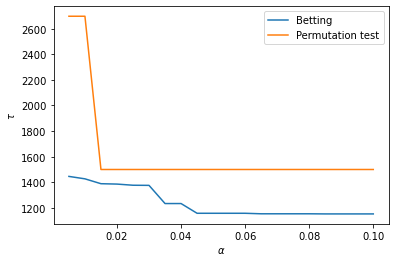

In [82]:
plt.plot(alphas, wealth_step, label='Betting')
plt.plot(alphas, perm_step, label='Permutation test')
plt.legend()
plt.xlabel('$\\alpha$')
plt.ylabel('$\\tau$')

In [67]:
alphas = [0.005, 0.01, 0.02, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
for alpha in alphas:
    wealth, seq_res = test_by_betting(y1, y1, alpha=alpha)
    print(len(wealth), seq_res)
#     step, perm_result = seq_perm_test(y1, y2, p=alpha, k=300, bonferroni=True)
#     print('Betting', seq_res, len(wealth), 'Perm', perm_result, step)


5759 sustain
5759 sustain
5759 sustain
5759 sustain
5759 sustain
5759 sustain
5759 sustain
5759 sustain
5759 sustain
5759 sustain


In [28]:
# seq_perm_test(y1, y2, p=0.05, k=100)
perm_test(y1[:1000], y2[:1000], p=0.05)

0.27586206896551724


False